<a href="https://colab.research.google.com/github/sarahjywu/Permafrost/blob/main/PermafrostConditions%26ALTPred_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
import seaborn as sns
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_components


In [ ]:


# Load condition and ALT datasets
df = pd.read_csv("/content/conditions.csv")
dfALT1 = pd.read_csv("/content/Cleaned_Cluster_1_ALT.csv")
dfALT2 = pd.read_csv("/content/ALT_Data_in_Centimeters.csv")

dfALT1 = dfALT1[["year", "lat", "lon", "ALT"]].copy()
dfALT2 = dfALT2[["year", "lat", "lon", "ALT"]].copy()

# Convert years to datetime
dfALT1["ds"] = pd.to_datetime(dfALT1["year"].astype(str), format="%Y")
dfALT2["ds"] = pd.to_datetime(dfALT2["year"].astype(str), format="%Y")
df["ds"] = pd.to_datetime(df["Year"].astype(str), format="%Y")

# Combine ALT datasets
dfALT = pd.concat([dfALT1, dfALT2], ignore_index=True)

# Drop rows with missing coordinates
print("ALT rows with missing coordinates:")
print(dfALT[dfALT[['lat', 'lon']].isnull().any(axis=1)])
print("Condition rows with missing coordinates:")
print(df[df[['Latitude', 'Longitude']].isnull().any(axis=1)])

dfALT = dfALT.dropna(subset=['lat', 'lon'])
df = df.dropna(subset=['Latitude', 'Longitude'])
df.head()


ALT rows with missing coordinates:
Empty DataFrame
Columns: [year, lat, lon, ALT, ds]
Index: []
Condition rows with missing coordinates:
Empty DataFrame
Columns: [Name, Year, Snow depth, air temperature [Â°C], Ground surface temperature [Â°C], Ground temperature at 25cm [Â°C], Ground temperature at  50cm [Â°C], Ground temperature at 75cm [Â°C], Ground temperature at 100cm [Â°C], Latitude, Longitude, ds]
Index: []


,Name,Year,Snow depth,air temperature [Â°C],Ground surface temperature [Â°C],Ground temperature at 25cm [Â°C],Ground temperature at 50cm [Â°C],Ground temperature at 75cm [Â°C],Ground temperature at 100cm [Â°C],Latitude,Longitude,ds
0,Drew Point,2001,0.290556,-16.3682,-10.07890,-11.26780,-10.69330,-10.34670,-12.2589,70.8645,-153.907,2001-01-01
1,Drew Point,2002,0.221786,-15.4285,-7.57429,-7.96286,-7.69571,-7.59857,-8.7400,70.8645,-153.907,2002-01-01
2,Drew Point,2003,0.232056,-16.4097,-9.24667,-10.03890,-9.64333,-9.41889,-10.8278,70.8645,-153.907,2003-01-01
3,Drew Point,2004,0.242222,-17.2089,-9.41000,-10.57330,-9.96000,-9.65556,-11.5789,70.8645,-153.907,2004-01-01
4,Drew Point,2005,0.167778,-15.9556,-10.04220,-11.18110,-10.53560,-10.26000,-12.0767,70.8645,-153.907,2005-01-01


In [ ]:
# Feature variables from condition dataset
feature_vars = [
    "Snow depth",
    "air temperature [Â°C]",
    "Ground surface temperature [Â°C]",
    "Ground temperature at 25cm [Â°C]",
    "Ground temperature at  50cm [Â°C]",
    "Ground temperature at 75cm [Â°C]",
    "Ground temperature at 100cm [Â°C]"
]

#  weights based on distances
weights_matrix = []
for _, alt_row in dfALT.iterrows():
    alt_coords = (alt_row['lat'], alt_row['lon'])
    distances = []
    for _, cond_row in df.iterrows():
        cond_coords = (cond_row['Latitude'], cond_row['Longitude'])
        dist = geodesic(alt_coords, cond_coords).km
        distances.append(1 / (dist ** 2 + 1e-6))  # Avoid divide by zero
    weights = np.array(distances) / sum(distances)
    weights_matrix.append(weights)

# Calculate weighted features
weighted_feature_data = []
for alt_idx, alt_row in dfALT.iterrows():
    weights = weights_matrix[alt_idx]
    weighted_features = {}
    for feature in feature_vars:
        weighted_features[feature] = np.average(df[feature], weights=weights)
    weighted_features['ds'] = alt_row['ds']
    weighted_features['lat'] = alt_row['lat']
    weighted_features['lon'] = alt_row['lon']
    weighted_features['ALT'] = alt_row['ALT']
    weighted_feature_data.append(weighted_features)



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5u_8ej46/90hov9_c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5u_8ej46/1q_wol_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73539', 'data', 'file=/tmp/tmp5u_8ej46/90hov9_c.json', 'init=/tmp/tmp5u_8ej46/1q_wol_9.json', 'output', 'file=/tmp/tmp5u_8ej46/prophet_model1c7vsc3_/prophet_model-20250715025854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:58:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:58:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test RMSE: 773.31
Test MAE: 19.29


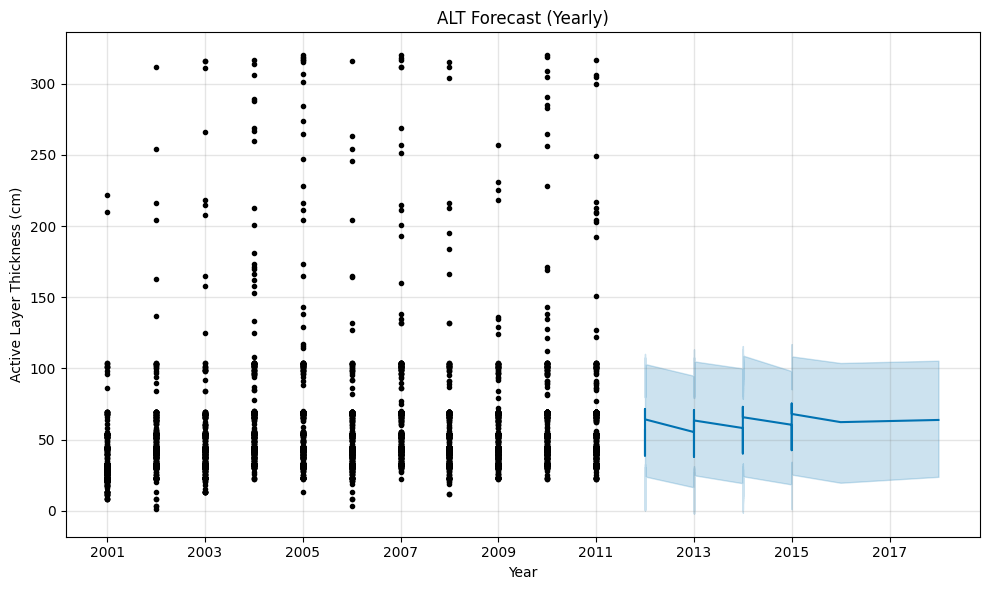

In [ ]:
# Prepare final DataFrame for Prophet
df_weighted_final = pd.DataFrame(weighted_feature_data)
df_weighted_final.rename(columns={"ALT": "y"}, inplace=True)

# Split into train and test sets based on year
train_df = df_weighted_final[df_weighted_final["ds"].dt.year < 2012]
test_df = df_weighted_final[df_weighted_final["ds"].dt.year >= 2012]

# Fit Prophet model on training data
model = Prophet()
for feature in feature_vars:
    model.add_regressor(feature)

model.fit(train_df)

# Forecast for the same dates as test data
future = test_df[["ds"]].copy()
for feature in feature_vars:
    future[feature] = test_df[feature]

forecast = model.predict(future)

# Merge actual and predicted values and handle NaN values
results = test_df[["ds", "y"]].merge(forecast[['ds', 'yhat']], on='ds', how='left')
results = results.dropna(subset=['y', 'yhat'])


# Evaluate (optional: calculate RMSE, MAE manually or use Prophet's metrics)
from prophet.diagnostics import performance_metrics, cross_validation
# Prophet's performance_metrics requires a cross-validation structure,
# but for custom RMSE:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(results["y"], results["yhat"])
mae = mean_absolute_error(results["y"], results["yhat"])

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# Plot predictions vs actuals
fig = model.plot(forecast)
plt.title("ALT Forecast (Yearly)")
plt.xlabel("Year")
plt.ylabel("Active Layer Thickness (cm)")
plt.tight_layout()
plt.show()